## Tutorial Refered
https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy

In [227]:
import pandas as pd
import numpy as np
import scipy as cp
import IPython
import warnings
warnings.filterwarnings('ignore')
import re as re
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
# from sklearn.linear_model import LogisticRegression, SGDClassifier
# from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score,confusion_matrix
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.cross_validation import KFold
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12, 8
import xgboost

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [124]:
# Train_data is used as train, validation and test
# Pred data is used for final output for submission, default set survived of pred to 0
train_data = pd.read_csv("train.csv", header = 0)
pred_data = pd.read_csv("test.csv", header = 0)
pred_data['Survived'] = 0
raw_data = pd.concat([train_data, pred_data])
full_data = [train_data, pred_data]
# raw_data.index = raw_data.PassengerId
train_data.tail();
pred_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0


### 4 C's of Data Cleaning: Correcting(outlier), Completing(missing value), Creating(Feature Engineering), Converting(categorical/string/object data to numerical which can fit in model)

In [125]:
print('Train Columns with null values:\n',train_data.isnull().sum())
print('----------------------')
print('Test/Pred Columns with null values:\n',pred_data.isnull().sum())
print('----------------------')
raw_data.describe(include = 'all')

Train Columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------------------
Test/Pred Columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Survived         0
dtype: int64
----------------------


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
count,1046.000000,295,1307,1308.000000,1309,1309.000000,1309.000000,1309.000000,1309,1309.000000,1309.000000,1309
unique,NaN,186,3,NaN,1307,NaN,NaN,NaN,2,NaN,NaN,929
top,NaN,C23 C25 C27,S,NaN,"Kelly, Mr. James",NaN,NaN,NaN,male,NaN,NaN,CA. 2343
freq,NaN,6,914,NaN,2,NaN,NaN,NaN,843,NaN,NaN,11
mean,29.881138,NaN,NaN,33.295479,NaN,0.385027,655.000000,2.294882,NaN,0.498854,0.261268,NaN
std,14.413493,NaN,NaN,51.758668,NaN,0.865560,378.020061,0.837836,NaN,1.041658,0.439494,NaN
min,0.170000,NaN,NaN,0.000000,NaN,0.000000,1.000000,1.000000,NaN,0.000000,0.000000,NaN
25%,21.000000,NaN,NaN,7.895800,NaN,0.000000,328.000000,2.000000,NaN,0.000000,0.000000,NaN
50%,28.000000,NaN,NaN,14.454200,NaN,0.000000,655.000000,3.000000,NaN,0.000000,0.000000,NaN
75%,39.000000,NaN,NaN,31.275000,NaN,0.000000,982.000000,3.000000,NaN,1.000000,1.000000,NaN


In [126]:
print(train_data.info())
# Conclude: 
# 1. Cabin has too many null entries, directly drop
# 2. Age and Embarked need to fill NA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


1.Pclass

In [127]:
print(train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index = False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


2.Sex

In [128]:
print(train_data[['Sex', 'Survived']].groupby(['Sex'], as_index = False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


3.SibSp and Parch: Family Size

In [129]:
# Feature Engineering to have 'Family Size' and 'IsAlone'
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
pred_data['FamilySize'] = pred_data['SibSp'] + pred_data['Parch'] + 1
print(train_data[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index = False).mean())
train_data['IsAlone'] = pred_data['IsAlone'] = 0
train_data.loc[train_data['FamilySize'] == 1, 'IsAlone'] = 1
pred_data.loc[pred_data['FamilySize'] == 1, 'IsAlone'] = 1
print(train_data[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index = False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000
   IsAlone  Survived
0        0  0.505650
1        1  0.303538


4.Embarked

In [130]:
# Fill missing value in Embark with mode
train_data['Embarked'] = train_data['Embarked'].fillna(train_data['Embarked'].mode()[0])
pred_data['Embarked'] = pred_data['Embarked'].fillna(train_data['Embarked'].mode()[0])
print(train_data[['Embarked', 'Survived']].groupby(['Embarked'], as_index = False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


5.Fare

In [131]:
# fill missing value in Fare with median
train_data['Fare'] = train_data['Fare'].fillna(train_data['Fare'].median())
pred_data['Fare'] = pred_data['Fare'].fillna(train_data['Fare'].median())
train_data['CategoricalFare'] = pd.qcut(train_data['Fare'],4)
pred_data['CategoricalFare'] = pd.qcut(pred_data['Fare'],4)
print(train_data[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index = False).mean())

   CategoricalFare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


6.Age

In [132]:
# Fill missing value in Age with Mean
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size = age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    #dataset['Age'] = dataset['Age'].astype(int)
    dataset['CategoricalAge'] = pd.cut(dataset['Age'],5)

print(train_data[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index = False).mean())

     CategoricalAge  Survived
0    (0.34, 16.336]  0.509091
1  (16.336, 32.252]  0.351598
2  (32.252, 48.168]  0.384030
3  (48.168, 64.084]  0.434783
4    (64.084, 80.0]  0.090909


7.Name

In [133]:
def get_title(name):
    title_search = re.search('([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
print(pd.crosstab(train_data['Title'], train_data['Sex']))                          

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


In [134]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt','Col',
                                                 'Don', 'Dr', 'Major','Rev','Sir','Jonkheer','Dona'],'Rare')
    dataset['Title'] = dataset['Title'].replace(['Mlle','Ms'], 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

print(train_data[['Title', 'Survived']].groupby(['Title'], as_index = False).mean())   

# # Another quantify way to deal with rare entry:
# stat_min = 10
# title_names = (train_data['Title'].value_counts()<stat_min)
# train_data['Title1'] = train_data['Title'].apply(lambda x: 'Rare' if title_names.loc[x] == True else x)
# print(train_data['Title1'].value_counts())

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


In [135]:
print(train_data.info())
print('-------------------------------')
print(pred_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
PassengerId        891 non-null int64
Survived           891 non-null int64
Pclass             891 non-null int64
Name               891 non-null object
Sex                891 non-null object
Age                891 non-null float64
SibSp              891 non-null int64
Parch              891 non-null int64
Ticket             891 non-null object
Fare               891 non-null float64
Cabin              204 non-null object
Embarked           891 non-null object
FamilySize         891 non-null int64
IsAlone            891 non-null int64
CategoricalFare    891 non-null category
CategoricalAge     891 non-null category
Title              891 non-null object
dtypes: category(2), float64(2), int64(7), object(6)
memory usage: 106.4+ KB
None
-------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 17 columns):
PassengerId   

In [136]:
# delete Cabin/PassengerID/Ticket/Name/Title1
drop_column = ['Cabin','PassengerId','Ticket','Name']
train_data.drop(drop_column, axis = 1, inplace = True)
pred_data.drop(drop_column, axis = 1, inplace = True)

In [137]:
pred_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Title
0,3,male,34.5,0,0,7.8292,Q,0,1,1,"(-0.001, 7.896]","(30.502, 45.668]",Mr
1,3,female,47.0,1,0,7.0000,S,0,2,0,"(-0.001, 7.896]","(45.668, 60.834]",Mrs
2,2,male,62.0,0,0,9.6875,Q,0,1,1,"(7.896, 14.454]","(60.834, 76.0]",Mr
3,3,male,27.0,0,0,8.6625,S,0,1,1,"(7.896, 14.454]","(15.336, 30.502]",Mr
4,3,female,22.0,1,1,12.2875,S,0,3,0,"(7.896, 14.454]","(15.336, 30.502]",Mrs


In [138]:
# Code Categorical data using label encoding
label = LabelEncoder()
for dataset in full_data:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['CategoricalFare_Code'] = label.fit_transform(dataset['CategoricalFare'])
    dataset['CategoricalAge_Code'] = label.fit_transform(dataset['CategoricalAge'])                       

In [139]:
# Define output variable as y
Target = ['Survived']

# Define x variable for originial features aka feature selection
data_x = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'FamilySize', 'IsAlone','Title']
# Coded for algorighm calculation
data_x_calc = ['Sex_Code', 'Embarked_Code', 'Title_Code',
        'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
data_xy = Target + data_x
print('Original X Y: ', data_xy, '\n')

# define x variable for original w/bin features to remove continuous variables
data_x_bin = ['Sex_Code', 'Embarked_Code', 'FamilySize',
        'CategoricalFare_Code', 'CategoricalAge_Code']
data_xy_bin = Target + data_x_bin
print('Bin X Y: ', data_xy_bin, '\n')

# define x and y variables for dummy features original
train_data_dummy = pd.get_dummies(train_data[data_x])
data_x_dummy = train_data_dummy.columns.tolist()
data_xy_dummy = Target + data_x_dummy
print('Dummy X Y: ', data_xy_dummy, '\n')

train_data_dummy.head()

# define x and y variables for final use
data_x_num_ca = ['Pclass','SibSp', 'Parch',
       'FamilySize', 'IsAlone', 'Sex_Code', 'Embarked_Code', 'Title_Code',
       'CategoricalFare_Code', 'CategoricalAge_Code']
data_xy_num_ca = Target + data_x_num_ca
print('Final X Y: ', data_xy_num_ca)

Original X Y:  ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'IsAlone', 'Title'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Embarked_Code', 'FamilySize', 'CategoricalFare_Code', 'CategoricalAge_Code'] 

Dummy X Y:  ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare'] 

Final X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'FamilySize', 'IsAlone', 'Sex_Code', 'Embarked_Code', 'Title_Code', 'CategoricalFare_Code', 'CategoricalAge_Code']


Da-Double Check cleaned Data

In [140]:
print('Train columns with null values: \n', train_data.isnull().sum())
print('-----------------------------')
print(train_data.info())
print('-----------------------------')
print('Prediction columns with null values: \n', pred_data.isnull().sum())
print('-----------------------------')
print(pred_data.info())

Train columns with null values: 
 Survived                0
Pclass                  0
Sex                     0
Age                     0
SibSp                   0
Parch                   0
Fare                    0
Embarked                0
FamilySize              0
IsAlone                 0
CategoricalFare         0
CategoricalAge          0
Title                   0
Sex_Code                0
Embarked_Code           0
Title_Code              0
CategoricalFare_Code    0
CategoricalAge_Code     0
dtype: int64
-----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
Survived                891 non-null int64
Pclass                  891 non-null int64
Sex                     891 non-null object
Age                     891 non-null float64
SibSp                   891 non-null int64
Parch                   891 non-null int64
Fare                    891 non-null float64
Embarked                891 non-null object


Split train test data in train_data set

In [141]:
train1_x, test1_x, train1_y, test1_y = train_test_split(train_data[data_x_calc], train_data[Target], random_state = 123)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = train_test_split(train_data[data_x_bin], train_data[Target], random_state = 123)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = train_test_split(train_data_dummy[data_x_dummy], train_data[Target], random_state = 123)

print('Train_data Shape: {}'.format(train_data.shape))
print('Train Set Shape: {}'.format(train1_x.shape))
print('Test Set Shape: {}'.format(test1_x.shape))
      

Train_data Shape: (891, 18)
Train Set Shape: (668, 8)
Test Set Shape: (223, 8)


## Step 4: Exploratory Analysis with Statistics

In [142]:
for x in data_x:
    if train_data[x].dtype != 'float64':
        print('Survival Correlation by: ', x)
        print(train_data[[x,Target[0]]].groupby(x, as_index = False).mean())
        print('-----------------------------\n')

# Using crosstabs
print(pd.crosstab(train_data['Title'], train_data[Target[0]]))

Survival Correlation by:  Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
-----------------------------

Survival Correlation by:  Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
-----------------------------

Survival Correlation by:  SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
-----------------------------

Survival Correlation by:  Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
-----------------------------

Survival Correlation by:  Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
-----------------------------

Survival Correlation by:  FamilySize
   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.72413

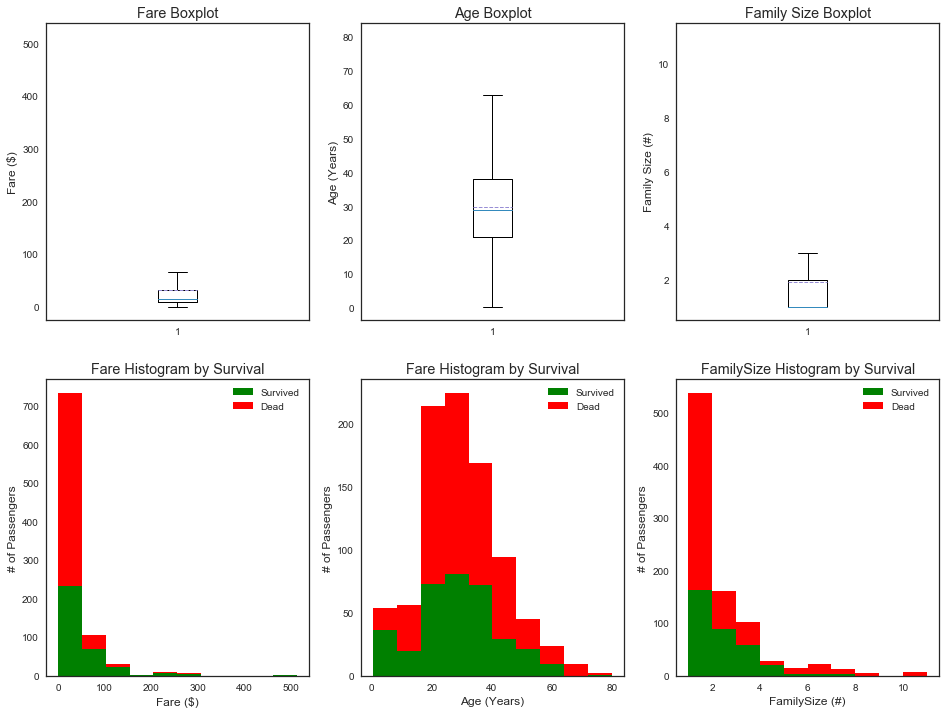

In [143]:
# graph distribution of quantitative data
plt.figure(figsize = [16,12])

plt.subplot(231)
plt.boxplot(x = train_data['Fare'], showmeans = True, meanline = True)
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(x = train_data['Age'], showmeans = True, meanline = True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

plt.subplot(233)
plt.boxplot(x = train_data['FamilySize'], showmeans = True, meanline = True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

plt.subplot(234)
plt.hist(x = [train_data[train_data.Survived==1]['Fare'], train_data[train_data.Survived==0]['Fare']],
         stacked = True, color = ['g','r'], label = ['Survived','Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x = [train_data[train_data.Survived==1]['Age'], train_data[train_data.Survived==0]['Age']],
         stacked = True, color = ['g','r'], label = ['Survived','Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x = [train_data[train_data.Survived==1]['FamilySize'], train_data[train_data.Survived==0]['FamilySize']],
         stacked = True, color = ['g','r'], label = ['Survived','Dead'])
plt.title('FamilySize Histogram by Survival')
plt.xlabel('FamilySize (#)')
plt.ylabel('# of Passengers')
plt.legend()


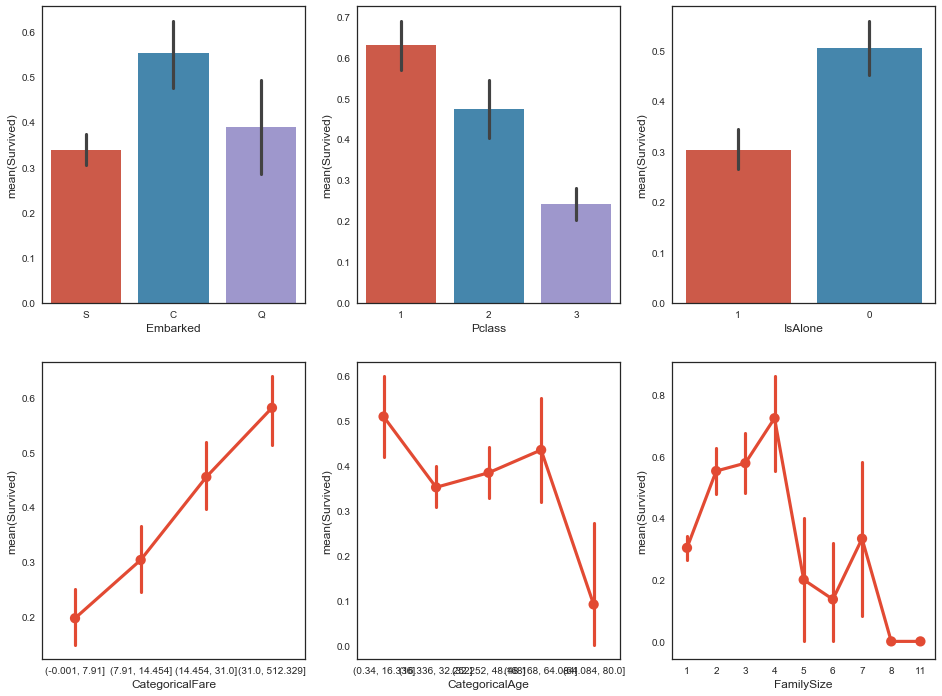

In [144]:
# use seaborn graphics for multi-variable comparison

# graph individual features by survival
fig, saxis = plt.subplots(2,3,figsize=(16,12))

sns.barplot(x = 'Embarked',y = 'Survived', data = train_data, ax = saxis[0,0])
sns.barplot(x = 'Pclass',y = 'Survived', order = [1,2,3], data = train_data, ax = saxis[0,1])
sns.barplot(x = 'IsAlone',y = 'Survived', order = [1,0], data = train_data, ax = saxis[0,2])

sns.pointplot(x = 'CategoricalFare', y = 'Survived', data = train_data, ax = saxis[1,0])
sns.pointplot(x = 'CategoricalAge', y = 'Survived', data = train_data, ax = saxis[1,1])
sns.pointplot(x = 'FamilySize', y = 'Survived', data = train_data, ax = saxis[1,2])

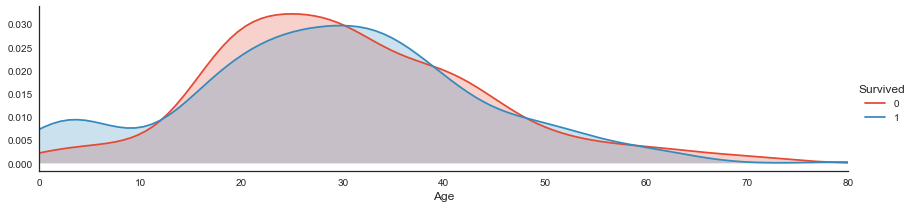

In [145]:
# plot distributions of age of passengers who survived or did not survive
a = sns.FacetGrid(train_data, hue = 'Survived', aspect = 4)
a.map(sns.kdeplot, 'Age', shade = True)
a.set(xlim = (0, train_data['Age'].max()))
a.add_legend()

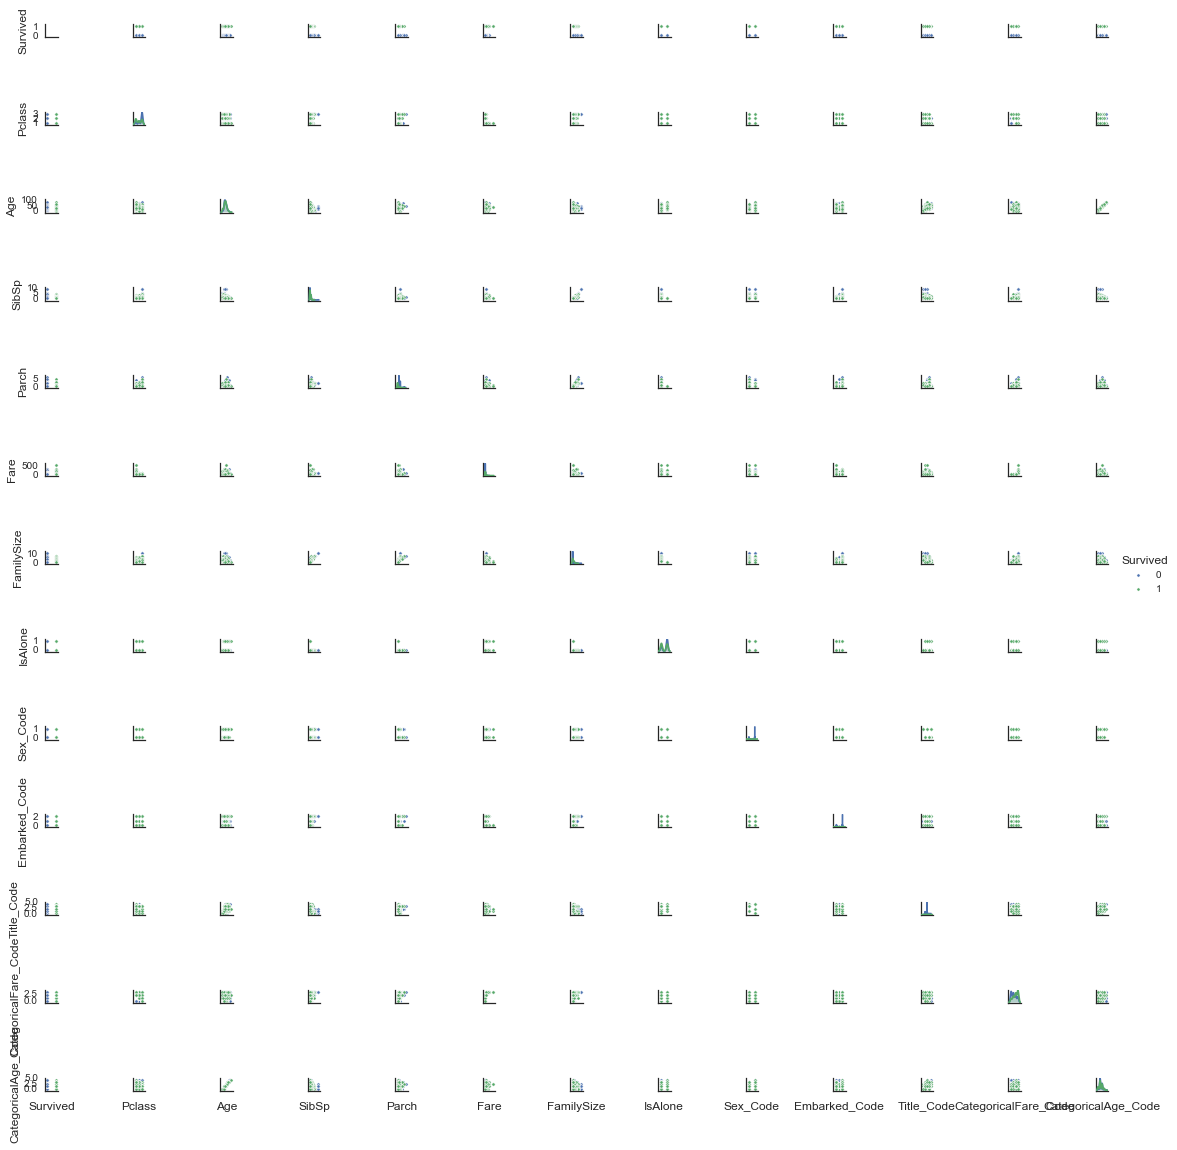

In [146]:
# Pair plots of entire dataset
pp = sns.pairplot(train_data, hue = 'Survived', palette = 'deep', size = 1.2, diag_kind = 'kde', diag_kws = dict(shade=True),plot_kws = dict(s=10))
pp.set(xticklabels=[])

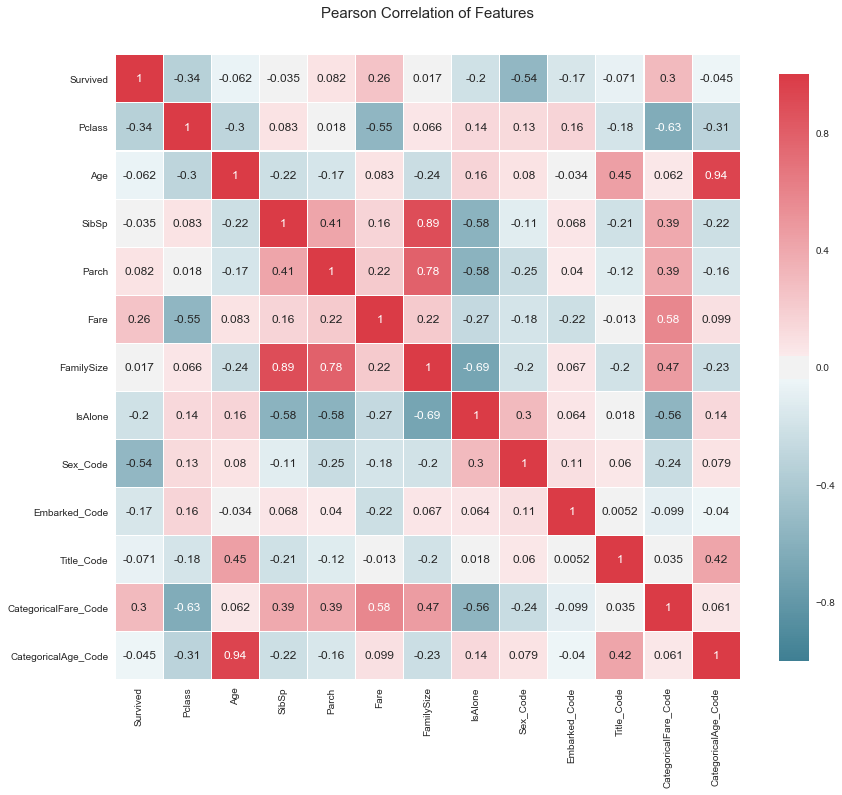

In [147]:
# correlation heatmap of dataset
def correlation_heatmap(df):
    _, ax = plt.subplots(figsize = (14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
    df.corr(),
    cmap = colormap,
    square = True,
    cbar_kws = {'shrink': .9},
    ax = ax,
    annot = True,
    linewidths = 0.1, vmax = 1.0, linecolor = 'white',
    annot_kws={'fontsize':12})
    
    plt.title('Pearson Correlation of Features', y = 1.05, size = 15)

correlation_heatmap(train_data)

In [148]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Title,Sex_Code,Embarked_Code,Title_Code,CategoricalFare_Code,CategoricalAge_Code
0,0,3,male,22.0,1,0,7.2500,S,2,0,"(-0.001, 7.91]","(16.336, 32.252]",Mr,1,2,2,0,1
1,1,1,female,38.0,1,0,71.2833,C,2,0,"(31.0, 512.329]","(32.252, 48.168]",Mrs,0,0,3,3,2
2,1,3,female,26.0,0,0,7.9250,S,1,1,"(7.91, 14.454]","(16.336, 32.252]",Miss,0,2,1,1,1
3,1,1,female,35.0,1,0,53.1000,S,2,0,"(31.0, 512.329]","(32.252, 48.168]",Mrs,0,2,3,3,2
4,0,3,male,35.0,0,0,8.0500,S,1,1,"(7.91, 14.454]","(32.252, 48.168]",Mr,1,2,2,1,2


## Data Modeling

In [274]:
# Machine Learning Algorithm Selection and Initialization
MLA = [
    # Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    # Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    # GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(), #? need to know how this model will work
    
    # Naive Bayes # need to know these two classifier?
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(), 
    
    # Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    # SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    # Trees
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    # Discriminant Analysis ? need to know this model better
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    # xgboost
    xgboost.XGBClassifier()
]

# Split dataset in cross-validation, and alternative way to train_test_split
# run model 10x with 60/30 split intentionally leaving out 10%
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0)

# create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Train Accuracy Mean', 'MLA Test Accuracy Mean',
              'MLA Test Accuracy 3*STD', 'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

# create table to compare MLA predictions
MLA_predict = train_data[Target]

# index through MLA and save performance to table
row_index = 0
for alg in MLA:
    
    # set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    # score model with cross validation
    cv_results = model_selection.cross_validate(alg, train_data[data_x_num_ca], train_data[Target], cv = cv_split)
    
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3
    
    #save MLA predictions
    alg.fit(train_data[data_x_num_ca], train_data[Target])
    MLA_predict[MLA_name] = alg.predict(train_data[data_x_num_ca])
    
    row_index += 1

MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)


In [275]:
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
14,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.837828,0.823881,0.0449994,0.0458452
15,NuSVC,"{'cache_size': 200, 'class_weight': None, 'coe...",0.835581,0.823507,0.0433687,0.0530262
21,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.858052,0.821642,0.0552491,0.0340134
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.895693,0.81791,0.0671269,0.0246636
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.872472,0.816418,0.0725111,0.066445
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.89794,0.816045,0.0534625,0.0158422
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.901685,0.810075,0.0607888,0.0159683
17,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.901685,0.809701,0.0700857,0.00203722
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.823783,0.809701,0.060696,0.0738622
5,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.881461,0.802985,0.0702286,0.136037


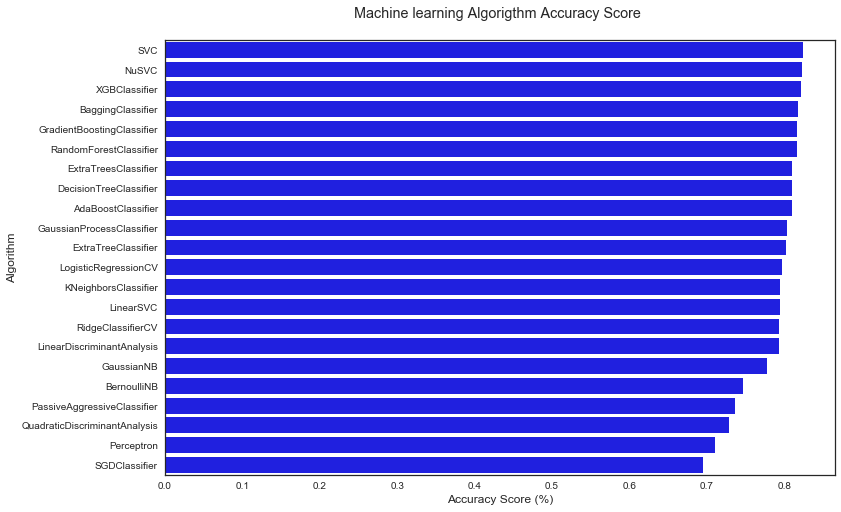

In [276]:
# barplot
sns.barplot(x = 'MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'b')

# prettify using pyplot
plt.title('Machine learning Algorigthm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')


In [152]:
train_data[data_x_bin]

,Sex_Code,Embarked_Code,FamilySize,CategoricalFare_Code,CategoricalAge_Code
0,1,2,2,0,1
1,0,0,2,3,2
2,0,2,1,1,1
3,0,2,2,3,2
4,1,2,1,1,2
5,1,1,1,1,2
6,1,2,1,3,3
7,1,2,5,2,0
8,0,2,3,1,1
9,0,0,2,2,0


In [153]:
train_data_dummy.head()

,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,3,22.0,1,0,7.2500,2,0,0,1,0,0,1,0,0,1,0,0
1,1,38.0,1,0,71.2833,2,0,1,0,1,0,0,0,0,0,1,0
2,3,26.0,0,0,7.9250,1,1,1,0,0,0,1,0,1,0,0,0
3,1,35.0,1,0,53.1000,2,0,1,0,0,0,1,0,0,0,1,0
4,3,35.0,0,0,8.0500,1,1,0,1,0,0,1,0,0,1,0,0


# Ensemble Model

In [208]:
ntrain = train_data.shape[0]
ntest = pred_data.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(ntrain, n_folds = NFOLDS, random_state = SEED)

# Class to extend the sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
    
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x,y)
    
    def feature_importances(self, x, y):
        try:
            return self.clf.fit(x, y).feature_importances_
        except:
            return self.clf.fit(x, y).coef_
        

In [209]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest, ))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1,1), oof_test.reshape(-1,1)

In [210]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators':500,
    'learning_rate': 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier paramters
svc_params = {
    'kernel': 'linear',
    'C': 0.025
}


In [211]:
# Create 5 objects that represent our models
rf = SklearnHelper(clf = ensemble.RandomForestClassifier, seed = SEED, params = rf_params)
et = SklearnHelper(clf = ensemble.ExtraTreesClassifier, seed = SEED, params = et_params)
ada = SklearnHelper(clf = ensemble.AdaBoostClassifier, seed = SEED, params = ada_params)
gb = SklearnHelper(clf = ensemble.GradientBoostingClassifier, seed = SEED, params = gb_params)
svc = SklearnHelper(clf = svm.SVC, seed = SEED, params = svc_params)

In [212]:
# Create Numpy arrays of train, test, and target dataframes to feed into our model
y_train = train_data[Target[0]].ravel()
x_train = train_data[data_x_num_ca].values
x_test = pred_data[data_x_num_ca].values

In [213]:
# Create our oof train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train,y_train,x_test)
rf_oof_train, rf_oof_test = get_oof(rf, x_train,y_train,x_test)
ada_oof_train, ada_oof_test = get_oof(ada, x_train,y_train,x_test)
gb_oof_train, gb_oof_test = get_oof(gb, x_train,y_train,x_test)
svc_oof_train, svc_oof_test = get_oof(svc, x_train,y_train,x_test)
print('Training is complete')

Training is complete


In [243]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train,y_train)
ada_feature = ada.feature_importances(x_train,y_train)
gb_feature = gb.feature_importances(x_train,y_train)
svc_feature = svc.feature_importances(x_train,y_train)[0]

In [244]:
cols = train_data[data_x_num_ca].columns.values
feature_dataframe = pd.DataFrame({'Features' : cols, 
                                  'Random Forest feature importances': rf_feature,
                                  'Extra Trees feature importances': et_feature,
                                  'AdaBoost feature importances': ada_feature,
                                  'Gradient Boost feature importances': gb_feature,
                                 'SVC feature imporances': svc_feature})

#### use interactive plotly package at this juncture to visualise the feature importances value of the different classifier via a plotly scatter plot by calling "Scatter" as follows

In [245]:
# Scatter plot function
def scatter_plot(clf):
    #l,sldfsdf
    trace = go.Scatter(
        y = feature_dataframe[clf].values,
        x = feature_dataframe['Features'].values,
        mode = 'markers',
        marker = dict(
            sizemode = 'diameter',
            sizeref = 1,
            size = 25,
            color = feature_dataframe[clf].values,
            colorscale = 'Portland',
            showscale = True
        ),
        text = feature_dataframe['Features'].values
    )
    data = [trace]

    layout = go.Layout(
        autosize = True,
        title = clf,
        hovermode = 'closest',
        yaxis = dict(
            title = 'Feature Importance',
            ticklen = 5,
            gridwidth = 2
        ),
        showlegend = False
    )

    fig = go.Figure(data = data, layout = layout)
    py.iplot(fig, filename = 'scatter2010')

In [247]:
clf_features = ['Random Forest feature importances','Extra Trees feature importances',
                'AdaBoost feature importances','Gradient Boost feature importances',
               'SVC feature imporances']
for clf in clf_features:
    scatter_plot(clf)



In [257]:
# Calculate the mean of feature importance from 4 models except for SVC
feature_dataframe['mean'] = feature_dataframe.loc[:,feature_dataframe.columns!='SVC feature imporances'].mean(axis=1)

#### plotly barplot of average feature importances

In [260]:
y = feature_dataframe['mean'].values
x = feature_dataframe['Features'].values
data = [go.Bar(
    x = x,
    y = y,
    width = 0.5,
    marker = dict(
        color = feature_dataframe['mean'].values,
        colorscale = 'Portland',
        showscale = True,
        reversescale = False
    ),
    opacity = 0.6
)]

layout  = go.Layout(
    autosize = True,
    title = 'Barplots of Mean Feature Importance',
    hovermode = 'closest',
    yaxis = dict(
        title = 'Feature Importance',
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend = False
)
fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'bar-direct-labels')

## Second Level Predictions from the First Level Output

In [262]:
base_predictions_train = pd.DataFrame({'RandomForest': rf_oof_train.ravel(),
                                       'ExtraTrees': et_oof_train.ravel(),
                                       'AdaBoost':ada_oof_train.ravel(),
                                       'GradientBoost': gb_oof_train.ravel(),
                                       'SVC':svc_oof_train.ravel()
                                      })
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest,SVC
0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0
2,1.0,0.0,0.0,0.0,1.0
3,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0


In [263]:
# correlation Heatmap of Second Level Training Set
data = [go.Heatmap(
    z = base_predictions_train.astype(float).corr().values,
    x = base_predictions_train.columns.values,
    y = base_predictions_train.columns.values,
    colorscale = 'Viridis',
    showscale = True,
    reversescale = True
)
]
py.iplot(data, filename = 'labelled-heatmap')

In [264]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train,gb_oof_train, svc_oof_train), axis = 1)
x_test = np.concatenate((et_oof_test,rf_oof_test,ada_oof_test,gb_oof_test,svc_oof_test), axis = 1)

In [266]:
gbm = xgboost.XGBClassifier(
    n_estimator = 2000,
    max_depth = 4,
    min_child_weight = 2,
    gamma = 0.9,
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = 'binary:logistic',
    nthread = -1,
    scale_pos_weight=1).fit(x_train,y_train)
predictions = gbm.predict(x_test)

ImportError: You must install graphviz to plot tree

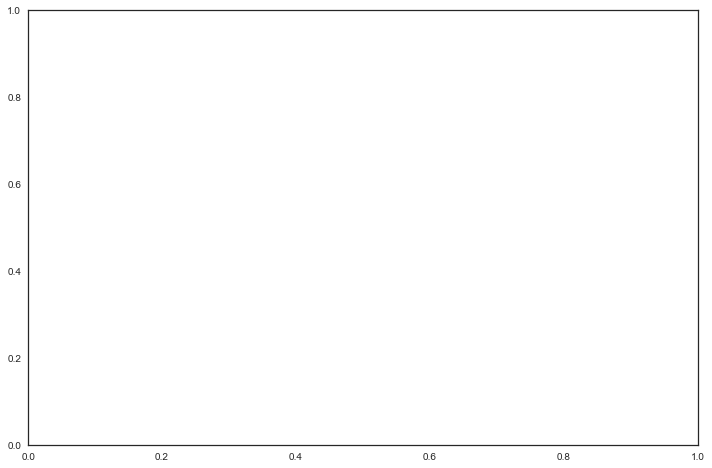

In [273]:
xgb.plot_tree(gbm)